## Data Preprocessing Facial Expression Recognition

##### In this notebook we are loading, cleaning and combining datasets in preparation for training our facial expression recognition model.  

##### Outline of this Notebook: 

[1. RAF-DB: Real Affective Faces - Database (29672 images)](#1.-RAF-DB:-Real-Affective-Faces-Database-(29672-images))<br>
[2. FePh: Facial Expression Phoenix (3359 images)](#2.-FePh:-Facial-Expression-Phoenix-(3359-images))<br>
[3. FER+: Facial Expression Recognition (35887 images)](#3.-FER+:-Facial-Expression-Recognition-(35887-images))<br>
[4. ExpW: Expressions in the Wild (84830 images)](#4.-ExpW:-Expressions-in-the-Wild-(84830-images))<br>
[5. Merging all cleaned datasets](#5.-Merging-all-cleaned-datasets)

#####  Information on how to obtain the original dataset from the internet is provided throughout the script. 

Comments: 

We initially started out with the RAF-DB dataset. While familiarizing ourselves with it, we noticed that it suffers from heavy class imbalance and has not so many images overall. If we were to train a model with a complex archtitecture on an imbalanced dataset and relatively small dataset, we are prone to overfitting. Therefore, our initial attempt to counter these risks are to increase the size of the dataset by adding more datasets that were created for the same task of facial expression recognition. 

In [79]:
import os
import numpy as np
import pandas as pd
from PIL import Image
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import shuffle
import time


### Settings ###
base_dir = "/Users/Felix/datasets/"
directory = base_dir + "facial_expression_full/"


<hr>

### 1. RAF-DB: Real Affective Faces Database (29672 images)

http://www.whdeng.cn/RAF/model1.html

Its' pictures were scraped from google and are not from a staged setting. Thus, we expect this dataset to be useful for our tasks of classifying facial expression in an uncontrolled setting. 

In this section we first inspect the dataset labels and relabel them to our wanted mapping. Then we proceed with cleaning the data and finally plot the distribution of labels per class. 


In [27]:
rafdb_df = pd.read_csv(directory + 'data_exp_rec/rafdb/Images/Aligned/list_patition_label.csv')
rafdb_df.head()

,file_name,label
0,train_00001.jpg,5
1,train_00002.jpg,5
2,train_00003.jpg,4
3,train_00004.jpg,4
4,train_00005.jpg,5


In [28]:
rafdb_df = rafdb_df.rename({'file_name':'image_name',}, axis = 1)
rafdb_df.image_name = rafdb_df.image_name.str.slice_replace(start=-3, repl='png')
rafdb_df.head()

,image_name,label
0,train_00001.png,5
1,train_00002.png,5
2,train_00003.png,4
3,train_00004.png,4
4,train_00005.png,5


Next, we relabel the pictures such that it matches the original label structure of the FER+ labels. (Note: In the training phase we have discovered that Tensorflow can only work with labels starting from 0. Therefore, we substract the value of 1 from each label to get the needed 0-6 label structure after we have combined all the datasets down below (see section 5 - [Readjust labels](#Readjust-labels)).

RAF-DB Original Mapping: <br>
1. surprise<br>
2. fear<br>
3. disgust<br>
4. happy<br>
5. sad<br>
6. anger<br>
7. neutral<br>

<hr>

Target Mapping:<br> 
1. neutral<br>
2. happy<br>
3. surprise<br>
4. sad<br>
5. anger<br>
6. disgust<br>
7. fear<br>

In [29]:
rafdb_df.label = rafdb_df.label.add(100) #to modify inplace

In [30]:
rafdb_df.label=rafdb_df.label.replace(to_replace=101,value=3)
rafdb_df.label=rafdb_df.label.replace(to_replace=102,value=7)
rafdb_df.label=rafdb_df.label.replace(to_replace=103,value=6)
rafdb_df.label=rafdb_df.label.replace(to_replace=104,value=2)
rafdb_df.label=rafdb_df.label.replace(to_replace=105,value=4)
rafdb_df.label=rafdb_df.label.replace(to_replace=106,value=5)
rafdb_df.label=rafdb_df.label.replace(to_replace=107,value=1)

In [31]:
rafdb_labels = rafdb_df

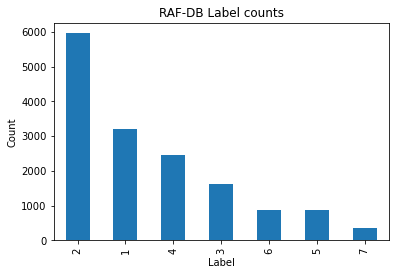

In [32]:
rafdb_labels.label.value_counts().plot(kind='bar')
plt.title('RAF-DB Label counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

We notice a strong class imbalance with only a couple of hundred images in some classes. Therefore, we start add next the FePh dataset.
<hr>

## 2. FePh: Facial Expression Phoenix (3359 images)

Alaghband, M., Yousefi, N., & Garibay, I. (2020). FePh: An Annotated Facial Expression Dataset for the RWTH-PHOENIX-Weather 2014 Dataset. arXiv preprint arXiv:2003.08759. 

Dataset Link: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/358QMQ

The FePh dataset contains labeled images of faces taken from TV recordings (mostly news segments).

In [33]:
FePh_lab_dir = directory + 'data_exp_rec/FePh/FePh_labels.csv'


In [34]:
temp3 = pd.read_csv(
    FePh_lab_dir,
    header = None,
    dtype={'2': 'int32'}
)

temp3.head()

,0,1,2,3
0,01August_2011_Monday_heute_default-6.avi_pid0_...,anger,1,0
1,01August_2011_Monday_heute_default-6.avi_pid0_...,anger,1,0
2,01August_2011_Monday_heute_default-6.avi_pid0_...,anger,1,0
3,01August_2011_Monday_heute_default-6.avi_pid0_...,anger,1,0
4,01August_2011_Monday_heute_default-6.avi_pid0_...,anger,1,0


In [35]:
temp3= temp3.rename({0:'image_name',
             1:'str_emo',
             2:'label',
             3:'train_test',}, axis=1)

In [36]:
temp3["label"].unique()

array(['1', '2', '63', '6', '7', '5', '0', '3', '65', '4', '40', '61',
       '51', '31', '21', '50', '53', '60', '52', '740',
       'Face_not_visible', '32', '62', nan, '10'], dtype=object)

In [37]:
temp3 = temp3[temp3["label"].notna()]
temp3 = temp3[temp3["label"] != 'Face_not_visible']
temp3.label = pd.to_numeric(temp3.label, errors='coerce').fillna('x').astype(np.int64)
temp3 = temp3[temp3["label"] < 7]
temp3["label"].unique()
cols_to_keep = ["image_name", "label"]
temp3 = temp3[cols_to_keep]

In [38]:
temp3.head()

,image_name,label
0,01August_2011_Monday_heute_default-6.avi_pid0_...,1
1,01August_2011_Monday_heute_default-6.avi_pid0_...,1
2,01August_2011_Monday_heute_default-6.avi_pid0_...,1
3,01August_2011_Monday_heute_default-6.avi_pid0_...,1
4,01August_2011_Monday_heute_default-6.avi_pid0_...,1


FePh Original Mapping: : <br>

0. neutral<br>
1. anger<br>
2. disgust<br>
3. fear<br>
4. happy<br>
5. sad<br>
6. surprise<br>

<hr>

Target Mapping:<br> 
1. neutral<br>
2. happy<br>
3. surprise<br>
4. sad<br>
5. anger<br>
6. disgust<br>
7. fear<br>

In [39]:
temp3.label = temp3.label.add(100) #create placeholder values to modify in place

In [40]:
temp3.label=temp3.label.replace(to_replace=100,value=1)
temp3.label=temp3.label.replace(to_replace=101,value=5)
temp3.label=temp3.label.replace(to_replace=102,value=6)
temp3.label=temp3.label.replace(to_replace=103,value=7)
temp3.label=temp3.label.replace(to_replace=104,value=2)
temp3.label=temp3.label.replace(to_replace=105,value=4)
temp3.label=temp3.label.replace(to_replace=106,value=3)

feph_labels = temp3
feph_labels.head()

,image_name,label
0,01August_2011_Monday_heute_default-6.avi_pid0_...,5
1,01August_2011_Monday_heute_default-6.avi_pid0_...,5
2,01August_2011_Monday_heute_default-6.avi_pid0_...,5
3,01August_2011_Monday_heute_default-6.avi_pid0_...,5
4,01August_2011_Monday_heute_default-6.avi_pid0_...,5


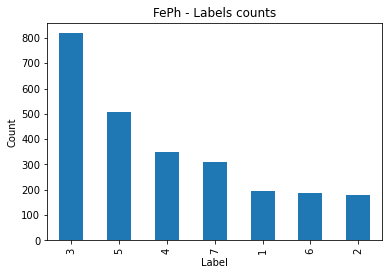

In [41]:
feph_labels.label.value_counts().plot(kind='bar')
plt.title('FePh - Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

This dataset is also unbalanced, but lass than RAF-DB. It is thus a useful addition to our collection of datasets.

<hr>

## 3. FER+: Facial Expression Recognition (35887 images)

The FER dataset is a collection of faces with particular expressions taken in a controlled setting. The FER dataset ground truth was improved by assigning new labels to the original pictures. Each of the 10 annotators cast a vote to which emotion class the picture belongs. Thus, the new labels are a distribution of 10 votes instead of a single number. We use the majority criterium as our best guess, as proposed by MS Research.

Link: 

New Labels: 
https://github.com/microsoft/FERPlus

Original Data: 
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

In [42]:
fer_orig_filedir = directory + 'data_exp_rec/fer2013/fer2013.csv'
fer_new_filedir = directory + 'data_exp_rec/FERPlus-master/fer2013new.csv'

fer_orig = pd.read_csv(fer_orig_filedir)
fer_newlabels = pd.read_csv(fer_new_filedir)

In [43]:
fer_orig = fer_orig.iloc[:,[1,2]] #drop the old emotion labels
fer_orig.head()

,pixels,Usage
0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [44]:
fer_newlabels.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


Next, we cast a majority vote on the emotions assigned to each picture. Since there are some ties (e.g. row index 3), we drop all pictures for which there are ties in the after merging the old and the new dataframe, resulting in less drop operations. 

In [45]:
def emot_maj_vote(ds):
    
    '''Among the selected columns containing integers,
        this function identifies the column with the highest integer
        and sets it to 1, while other selected columns are zeroed'''
    
    affected = (ds != 0).any(axis=1)
    cols = ds.loc[affected]
    ds[affected] = (cols.T == cols.max(axis=1)).T.astype(int)
    return ds

split1 = fer_newlabels.loc[:,['Usage', 'Image name']]
split2 = fer_newlabels.iloc[:, 2:]
split2_max = emot_maj_vote(split2)
fer_new= pd.concat([split1, split2_max], axis=1)
fer_new.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,1,0,0,0,0,0,0,0,0,0
1,Training,fer0000001.png,1,0,0,0,0,0,0,0,0,0
2,Training,fer0000002.png,1,0,0,0,0,0,0,0,0,0
3,Training,fer0000003.png,1,0,0,1,0,0,0,0,0,0
4,Training,fer0000004.png,1,0,0,0,0,0,0,0,0,0


Merging the old dataframe with the picture data + old labels with the new labels

In [46]:
# Check if we can merge the data!
assert len(fer_orig) == len(fer_new)
fer_final= pd.concat([fer_orig, fer_new], axis=1)
assert len(fer_final) == len(fer_orig)

In [47]:
column_list = list(fer_final)
print(column_list)

['pixels', 'Usage', 'Usage', 'Image name', 'neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']


In [48]:
#drop superfluous rows
column_list.remove("Usage")
column_list.remove("Usage") #we have two "Usage" columns
fer_final = fer_final[column_list]
fer_final.head()

,pixels,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,fer0000000.png,1,0,0,0,0,0,0,0,0,0
1,151 150 147 155 148 133 111 140 170 174 182 15...,fer0000001.png,1,0,0,0,0,0,0,0,0,0
2,231 212 156 164 174 138 161 173 182 200 106 38...,fer0000002.png,1,0,0,0,0,0,0,0,0,0
3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,fer0000003.png,1,0,0,1,0,0,0,0,0,0
4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,fer0000004.png,1,0,0,0,0,0,0,0,0,0


Next, we drop the ties by summing across all emotion rows, when sum != 1, it is a tie.

In [49]:
column_list1 = list(fer_final)
print(column_list1)
column_list1.remove("pixels")
column_list1.remove("Image name")

#drop all pictures that have more than one label
fer_final["row_sum"] = fer_final[column_list1].sum(axis=1)
fer_final = fer_final[fer_final["row_sum"] == 1]
assert fer_final.row_sum.unique() == 1 
del fer_final['row_sum']

['pixels', 'Image name', 'neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']


In [50]:
fer_final.head()

,pixels,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,fer0000000.png,1,0,0,0,0,0,0,0,0,0
1,151 150 147 155 148 133 111 140 170 174 182 15...,fer0000001.png,1,0,0,0,0,0,0,0,0,0
2,231 212 156 164 174 138 161 173 182 200 106 38...,fer0000002.png,1,0,0,0,0,0,0,0,0,0
4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,fer0000004.png,1,0,0,0,0,0,0,0,0,0
5,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,fer0000005.png,1,0,0,0,0,0,0,0,0,0


After merging the old and the new dataframe with the image pixel data,
we have to drop the following rows and colums:
* the rows with NAN in the image_name column
* the rows which contains images belonging to the emotion categories: 
        - contempt
        - unknown 
        - NF
* subsequently, we drop the columns contempt, unknown, NF

In [51]:
fer_final = fer_final.rename({'Image name': 'image_name',}, axis=1)
fer_final.image_name = fer_final.image_name.dropna()

fer_final = fer_final[fer_final.contempt == 0]
fer_final = fer_final[fer_final.unknown == 0]
fer_final = fer_final[fer_final.NF == 0]

fer_final = fer_final.iloc[:,:9]
fer_final.head()

,pixels,image_name,neutral,happiness,surprise,sadness,anger,disgust,fear
0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,fer0000000.png,1,0,0,0,0,0,0
1,151 150 147 155 148 133 111 140 170 174 182 15...,fer0000001.png,1,0,0,0,0,0,0
2,231 212 156 164 174 138 161 173 182 200 106 38...,fer0000002.png,1,0,0,0,0,0,0
4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,fer0000004.png,1,0,0,0,0,0,0
5,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,fer0000005.png,1,0,0,0,0,0,0


Assign the "one-hot" columns our wanted emotion mapping and then manipulate the dataframe in the wanted two column format, where the first column contains the image names and the second column the corresponding labels:

In [52]:
fer_final = fer_final.replace(to_replace = {'neutral': 1,
                                'happiness': 1,
                                'surprise': 1,
                                'sadness': 1,
                                'anger':1,
                                'disgust':1,
                                'fear':1
                               },
                  value = {'neutral': 1,
                                'happiness': 2,
                                'surprise': 3,
                                'sadness': 4,
                                'anger':5,
                                'disgust':6,
                                'fear':7
                               },
                               )

In [53]:
col_list_temp = list(fer_final)
print(col_list_temp)

col_list_temp.remove("pixels")
col_list_temp.remove("image_name")

['pixels', 'image_name', 'neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']


In [54]:
fer_final["label"] = fer_final[col_list_temp].sum(axis=1).astype(np.int32) 
labels_to_keep = ["image_name","label"]
fer_labels = fer_final[labels_to_keep]

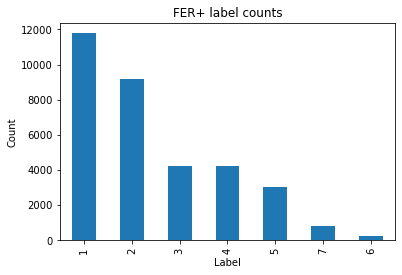

In [55]:
fer_labels.label.value_counts().plot(kind='bar')
plt.title('FER+ label counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

Also the FER+ dataset suffers from a strong class imbalance for the categories fear and disgust.

To create a single folder with all images, we convert the pixels to 48x48 images and save them in the directory!

Note: Since the FER images are grayscaled, we stack three tiles of the same image on top of each other to create 3 channels in disguise. In this way, we can easily feed the images into our neural network.  

In [56]:
path = directory + "data_exp_rec/ferimages/"

if os.path.exists(filePath):
    #os.remove(filePath)

def save_as_img():
    for index,row in temp.iterrows():
        pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
        img=pixels.reshape((48,48))
        stacked_image = np.dstack((img,) * 3) 
        pathname= os.path.join(path + x[index])
        cv2.imwrite(pathname,img)
        print('image saved ias {}'.format(pathname))
        
#Run:
#save_as_img()

<hr>

## 4. ExpW: Expressions in the Wild (84830 images) 


The ExpW dataset contains images in various settings and is very heterogeneous. The large amount of images helps us to get enough data for training our facial expression recognition model. 

Original source: 
http://mmlab.ie.cuhk.edu.hk/projects/socialrelation/index.html

Link to a cleaned version of the dataset:
https://github.com/markson14/ExpWCleaned

Download Data: 
https://drive.google.com/file/d/1vHGIbanzDLbweY_UYyy_EfdWh1-lpVEa/view


In [57]:
expw_df = pd.read_csv(directory + "/ExpWCleaned-master/label_expw.csv", header = None)
expw_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,awe_grandmother_214_0.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0
1,mad_woman_303_0.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0
2,fierce_european_896_0.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0
3,annoyed_father_453_0.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0
4,mad_infant_734_0.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0


In [58]:
temp2 = expw_df.rename({0: 'image_name',
                     1:'img_size',
                     2:'neutral',
                     3:'happiness',
                     4:'surprise',
                     5:'sadness',
                     6:'anger',
                     7:'disgust',
                     8:'fear',
                     9: 'contempt',
                    10: 'unknown',
                    11:'NF'}, axis='columns')

temp2.head()

,image_name,img_size,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,awe_grandmother_214_0.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0
1,mad_woman_303_0.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0
2,fierce_european_896_0.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0
3,annoyed_father_453_0.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0
4,mad_infant_734_0.png,"(0, 0, 48, 48)",0,0,0,0,0,0,10,0,0,0


First, we check for ties in in labeling. If this is the case, we drop the image from our dataframe and do not use it in our analysis further. 

In [59]:
column_list1 = list(temp2)
print(column_list1)
column_list1.remove("image_name")
column_list1.remove("img_size")
temp2["row_sum"] = temp2[column_list1].sum(axis=1)
temp2 = temp2[temp2["row_sum"] == 10]
del temp2['row_sum']

['image_name', 'img_size', 'neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt', 'unknown', 'NF']


We drop the following rows:
* the rows with NAN in the image_name column
* the rows which contains images belonging to the emotion categories: 
        - contempt
        - unknown 
        - NF
* then we prepare the dataframe for assigning our wanted label emotion mapping.

In [60]:
temp2 = temp2[temp2.image_name.notnull()]
temp2 = temp2[temp2.contempt.notnull()]
temp2 = temp2[temp2.unknown.notnull()]
temp2 = temp2[temp2.NF.notnull()]
temp2 = temp2.iloc[:,[0,2,3,4,5,6,7,8]]

In [61]:
# assign new labels to have a sparse label layout
temp2 = temp2.replace(to_replace = {'neutral': 10,
                                'happiness': 10,
                                'surprise': 10,
                                'sadness': 10,
                                'anger':10,
                                'disgust':10,
                                'fear':10
                               },
                  value = {'neutral': 1,
                                'happiness': 2,
                                'surprise': 3,
                                'sadness': 4,
                                'anger':5,
                                'disgust':6,
                                'fear':7
                               },
                               )

temp2.head()

,image_name,neutral,happiness,surprise,sadness,anger,disgust,fear
0,awe_grandmother_214_0.png,0,0,0,0,0,0,7
1,mad_woman_303_0.png,0,0,0,0,0,0,7
2,fierce_european_896_0.png,0,0,0,0,0,0,7
3,annoyed_father_453_0.png,0,0,0,0,0,0,7
4,mad_infant_734_0.png,0,0,0,0,0,0,7


After some dataframe manipulation, we coerce the dataframe in the desired image_name, label shape.

In [62]:
col_list_temp2 = list(temp2)
print(col_list_temp2)

['image_name', 'neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']


In [63]:
temp2["label"] = temp2[col_list_temp2].sum(axis=1).astype(np.int32) #this makes a new label column
cols_to_keep = ["image_name", "label"]
expw_labels= temp2[cols_to_keep]
expw_labels

,image_name,label
0,awe_grandmother_214_0.png,7
1,mad_woman_303_0.png,7
2,fierce_european_896_0.png,7
3,annoyed_father_453_0.png,7
4,mad_infant_734_0.png,7
...,...,...
84825,awe_father_957_0.png,6
84826,distressed_actor_177_0.png,6
84827,hostile_mother_562_0.png,6
84828,distressed_actor_971_0.png,6


Note: The label structure of the ExpW coincides with our target label structure of the FER+ dataset and therefore we do not need to relabel it. 

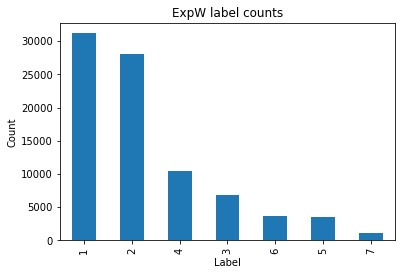

In [64]:
expw_labels.label.value_counts().plot(kind='bar')
plt.title('ExpW label counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

Also the ExpW dataset is very imbalanced. But once we combine all datasets in the next steps, we have a sufficient amount of images per class to work with.
<hr>

## 5. Merging all cleaned datasets

In [65]:
expw_labels.shape, fer_labels.shape, feph_labels.shape, rafdb_labels.shape

((84830, 2), (33500, 2), (2544, 2), (15339, 2))

In [66]:
df_all= pd.concat([expw_labels, fer_labels, feph_labels, rafdb_labels], axis=0)
df_all= shuffle(df_all) #randomly shuffle the data to mix the different datasets!
df_all["label"].unique()

In [68]:
df_all.shape

(136213, 2)

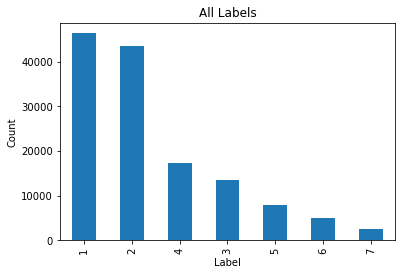

In [69]:
df_all.label.value_counts().plot(kind='bar')
plt.title('All Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

The combined dataset is still unbalanced. But the minority classes have also contain more than 2500 unique images. In the training set preproccessing, we are going to account for this imbalance by randomly oversampling the minority classes and randomly undersampling the majority classes, such that the training set is balanced. 

In [71]:
df_all.label.value_counts()

1    46361
2    43447
4    17426
3    13526
5     7948
6     4981
7     2524
Name: label, dtype: int64

#### Readjusting labels

Next we readjust labels such that tensorflow has the desired label input beginning with 0. We achieve this by substracting the value 1 from each label.

In [72]:
df_all.loc[:,'label'] = df_all.loc[:,'label'].sub(1)
df_all.label.value_counts()

0    46361
1    43447
3    17426
2    13526
4     7948
5     4981
6     2524
Name: label, dtype: int64

In [84]:
df_all.to_csv(directory +'expression_main/labels/expression_labels.csv', sep='\t', encoding='utf-8', index=False)

##### Next we are grayscaling all pictures and save them in a new directory!

READ ME: The code below needs not to run, as the submitted folder already contains the grayscaled images. It is just included here for the sake of completeness.  

In [57]:
# Creating a new folder for storing the grayscaled images

#drop .DS_Store files!  
#df_all.drop(df_all.loc[df_all['image_name'] == ".DS_Store"].index, inplace=True)
#df_all.drop(df_all.loc[df_all['label'] == ".DS_Store"].index, inplace=True)

#new_folder = directory + '/expression_main/grayscaled_images/'
#if not os.path.exists(new_folder):
#    os.makedirs(new_folder) 

#grab the image names from the dataframe
#img_names = df_all['image_name']
#print(len(img_names))
#def conv_grayscale(image_name_list):
#    for img in image_name_list:
#        name = img
#        img = Image.open(directory + '/expression_main/images/' + img).convert('LA')
#        img.save(new_folder+name)
#    return None


#start_time = time.time()
#conv_grayscale(img_names) #uncomment this to run. It takes about 13 minutes on a business laptop.
#print("--- %s seconds ---" % (time.time() - start_time))

136198


Now we have all of our images in grayscale format and have them stored in a single folder. Another folder contains the csv file with all corresponding labels from 0:neutral - 6: fear. 

Next we switch to the notebook: Emotion_Training